In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.models import resnet152
from torch.utils.data import DataLoader
import numpy as np
import os

transforms = transforms.Compose([
    transforms.CenterCrop(224), transforms.ToTensor() 
])

root = "/root/"

train_dataset = FashionMNIST(
    root=root, train=True, transform=transforms, download=True
)

val_dataset = FashionMNIST(
    root=root, train=False, transform=transforms, download=True
)



In [3]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)



In [3]:
print(next(iter(val_dataloader)))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [4]:
class Resnet(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self._initModel(num_classes)

    def _initModel(self, num_classes):
        pre_model = resnet152(pretrained=True)
        num_fc_in_features = pre_model.fc.in_features
        pre_model.fc = nn.Linear(num_fc_in_features, num_classes)
        pre_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model = pre_model

    def forward(self, images):
        outputs = self.model(images)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Resnet(num_classes=10)
model = model.to(device)

c:\Users\yuhei\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuhei\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(model)

Resnet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [5]:
class EarlyStopping:
    def __init__(self, patience):
        self.check_count = 0
        self.patience = patience

    def checkCount(self, _bool):
        if _bool:
            self.check_count = 0
        else:
            self.check_count += 1

        if self.check_count == self.patience:
            return 0
        else:
            return None
        

In [6]:
early_stopping = EarlyStopping(patience=3)


In [7]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [11]:
epochs = 1
output_dir = "./output"
check = None
train_loss_list = []
train_correct_list =[]
val_loss_list = []
val_correct_list = []

for epoch in range(epochs):
    for step in ["train", "val"]:
        running_loss = 0.0
        running_corrects = 0.0
        min_loss = np.inf
        if step == "train":
            model.train()
            dataloader = train_dataloader
        else:
            model.eval()
            dataloader = val_dataloader
        for batch, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(step=="train"):
                outputs = model(images)
                pred = torch.argmax(outputs, dim=-1)
                loss = (criterion(outputs, labels))
                correct = (torch.sum(pred == labels)) / batch_size

                if step == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += correct.item()
            if step == "train":
                print(f"STEP: Train Epoch: {epoch + 1}/{epochs} Iteration: {batch + 1}/{len(dataloader)} train_loss{running_loss / (batch + 1)}")

            else:
                print(f"STEP: VAL Epoch: {epoch + 1}/{epochs} Iteration: {batch + 1}/{len(dataloader)} val_loss{running_loss / (batch + 1)} val_correct: {running_corrects / (batch + 1)}")
                
        if step == "train":
            train_loss_list.append(running_loss / (batch + 1))
            train_correct_list.append(running_corrects / (batch + 1))
        else:
            val_loss_list.append(running_loss / (batch + 1))
            val_correct_list.append(running_corrects / (batch + 1))     

    if running_loss < min_loss:
        early_stopping.checkCount(True)
        print("Model Save !")
        min_loss = running_loss
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        torch.save(model.state_dict(), os.path.join(output_dir, "model.pth"))
    else:
        check = early_stopping.checkCount(False)
    if check == 0:
        print("Early Stopping !") 
        break


STEP: Train Epoch: 1/1 Iteration: 1/1875 train_loss0.23555335402488708
STEP: Train Epoch: 1/1 Iteration: 2/1875 train_loss0.21707481145858765
STEP: Train Epoch: 1/1 Iteration: 3/1875 train_loss0.23578527569770813
STEP: Train Epoch: 1/1 Iteration: 4/1875 train_loss0.21897951513528824
STEP: Train Epoch: 1/1 Iteration: 5/1875 train_loss0.27478161454200745
STEP: Train Epoch: 1/1 Iteration: 6/1875 train_loss0.25891172140836716
STEP: Train Epoch: 1/1 Iteration: 7/1875 train_loss0.29184780589171816
STEP: Train Epoch: 1/1 Iteration: 8/1875 train_loss0.2910811398178339
STEP: Train Epoch: 1/1 Iteration: 9/1875 train_loss0.28937044574154747
STEP: Train Epoch: 1/1 Iteration: 10/1875 train_loss0.2883211746811867
STEP: Train Epoch: 1/1 Iteration: 11/1875 train_loss0.28545721958984027
STEP: Train Epoch: 1/1 Iteration: 12/1875 train_loss0.27171996732552844
STEP: Train Epoch: 1/1 Iteration: 13/1875 train_loss0.2617832147158109
STEP: Train Epoch: 1/1 Iteration: 14/1875 train_loss0.2629323090825762
STEP:

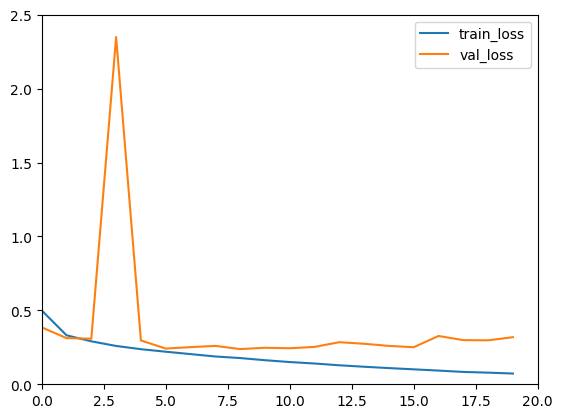

In [22]:
import matplotlib.pyplot as plt

plt.xlim(0, 20)
plt.ylim(0, 2.5)
plt.plot(range(epochs), train_loss_list, label="train_loss")
plt.plot(range(epochs), val_loss_list, label="val_loss")
plt.legend()
plt.show()

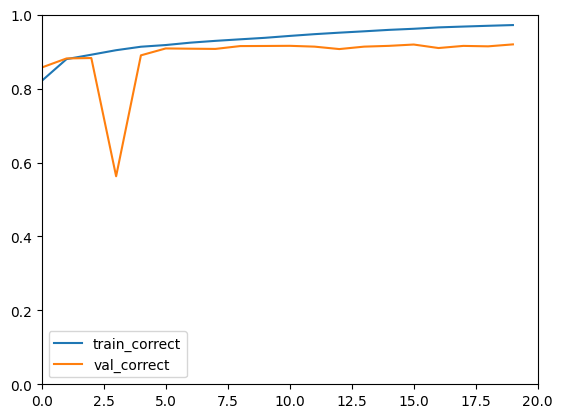

In [23]:
plt.xlim(0, 20)
plt.ylim(0, 1.0)
plt.plot(range(epochs), train_correct_list, label="train_correct")
plt.plot(range(epochs), val_correct_list, label="val_correct")
plt.legend()
plt.show()

In [27]:
import numpy as np

print(f"Index :{np.argmax(val_correct_list)} Max correct : {np.max(val_correct_list)}")

Index :19 Max correct : 0.9196285942492013
